In [156]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

import torch
import torch.nn as nn

import random
from tqdm import tqdm
import optuna

import pmdarima as pm

import datetime


In [60]:
df = pd.read_csv("../../preprocessed_data/[10분 단위]아파트_층별_소비전력_2023-03-16 06.30.00 ~ 2023-08-30 10.30.00.csv", usecols=[1,2,3,4])

df

,TIMESTAMP,BUILDING,FLOOR,CONSUMPTION(W)
0,2023-03-16 06:30:00,561,1,225
1,2023-03-16 06:40:00,561,1,217
2,2023-03-16 06:50:00,561,1,212
3,2023-03-16 07:00:00,561,1,88
4,2023-03-16 07:10:00,561,1,435
...,...,...,...,...
1588813,2023-08-30 09:50:00,563,24,366
1588814,2023-08-30 10:00:00,563,24,545
1588815,2023-08-30 10:10:00,563,24,567
1588816,2023-08-30 10:20:00,563,24,547


In [108]:
df_561_1 = df.query("`BUILDING` == 561 and `FLOOR` == 1")

df_561_1['TIMESTAMP'] = pd.to_datetime(df_561_1['TIMESTAMP'])
df_561_1.set_index(df_561_1['TIMESTAMP'], drop=True, inplace=True)
df_561_1.drop(['BUILDING', 'FLOOR','TIMESTAMP'], axis=1, inplace=True)
df_561_1['CONSUMPTION(W)'] /= 1000.0
df_561_1 = df_561_1.resample(rule='60T').max()
df_561_1

C:\Users\hansung\AppData\Local\Temp\ipykernel_18536\3795945787.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_561_1['TIMESTAMP'] = pd.to_datetime(df_561_1['TIMESTAMP'])
C:\Users\hansung\AppData\Local\Temp\ipykernel_18536\3795945787.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_561_1.drop(['BUILDING', 'FLOOR','TIMESTAMP'], axis=1, inplace=True)
C:\Users\hansung\AppData\Local\Temp\ipykernel_18536\3795945787.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

,CONSUMPTION(W)
TIMESTAMP,
2023-03-16 06:00:00,0.225
2023-03-16 07:00:00,0.435
2023-03-16 08:00:00,0.323
2023-03-16 09:00:00,0.346
2023-03-16 10:00:00,0.335
...,...
2023-08-30 06:00:00,0.490
2023-08-30 07:00:00,0.482
2023-08-30 08:00:00,0.505


<Axes: xlabel='TIMESTAMP'>

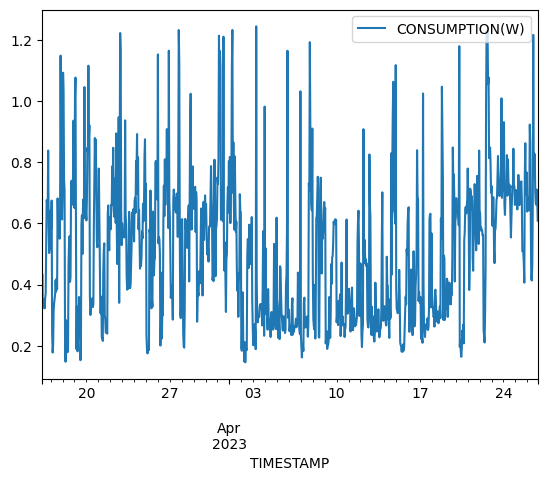

In [109]:
df_561_1.head(1000).plot()

In [113]:
df_561_2 = df.query("`BUILDING` == 561 and `FLOOR` == 2")
df_561_2['TIMESTAMP'] = pd.to_datetime(df_561_2['TIMESTAMP'])
df_561_2.drop(['BUILDING', 'FLOOR'], axis=1, inplace=True)
df_561_2.set_index('TIMESTAMP', inplace=True)
df_561_2['CONSUMPTION(W)'] /= 1000.0
df_561_2 = df_561_2.resample(rule='60T').max()
df_561_2


C:\Users\hansung\AppData\Local\Temp\ipykernel_18536\2118972478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_561_2['TIMESTAMP'] = pd.to_datetime(df_561_2['TIMESTAMP'])
C:\Users\hansung\AppData\Local\Temp\ipykernel_18536\2118972478.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_561_2.drop(['BUILDING', 'FLOOR'], axis=1, inplace=True)
C:\Users\hansung\AppData\Local\Temp\ipykernel_18536\2118972478.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,CONSUMPTION(W)
TIMESTAMP,
2023-03-16 06:00:00,0.256
2023-03-16 07:00:00,0.361
2023-03-16 08:00:00,0.736
2023-03-16 09:00:00,0.791
2023-03-16 10:00:00,1.098
...,...
2023-08-30 06:00:00,0.305
2023-08-30 07:00:00,0.553
2023-08-30 08:00:00,0.386


<Axes: xlabel='TIMESTAMP'>

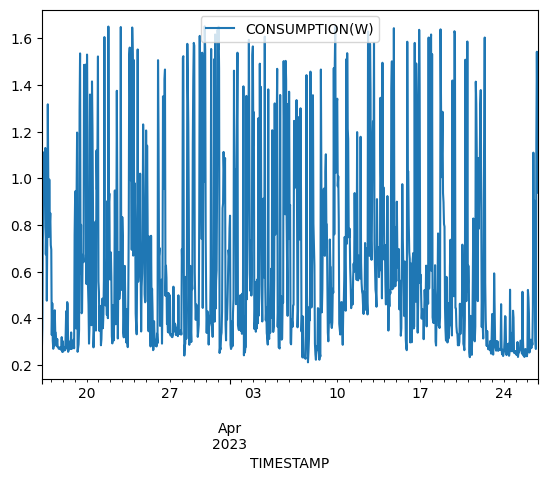

In [114]:
df_561_2.head(1000).plot()

<Axes: xlabel='TIMESTAMP'>

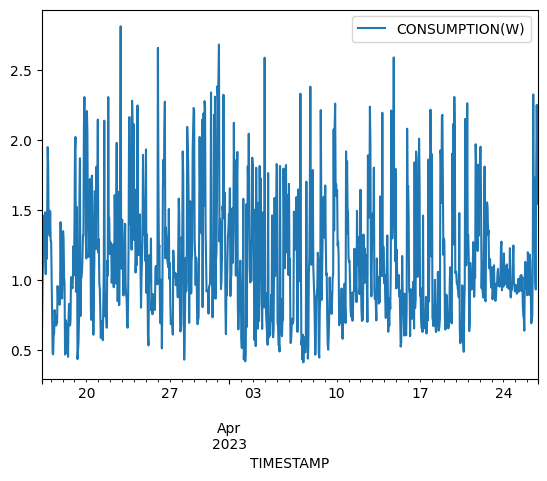

In [115]:
df_12 = df_561_1 + df_561_2

df_12.head(1000).plot()

In [116]:
df_561_3 = df.query("`BUILDING` == 561 and `FLOOR` == 3")
df_561_3['TIMESTAMP'] = pd.to_datetime(df_561_3['TIMESTAMP'])
df_561_3.drop(['BUILDING', 'FLOOR'], axis=1, inplace=True)
df_561_3.set_index('TIMESTAMP', inplace=True)
df_561_3['CONSUMPTION(W)'] /= 1000.0
df_561_3 = df_561_3.resample(rule='60T').max()
df_561_3

C:\Users\hansung\AppData\Local\Temp\ipykernel_18536\1501524749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_561_3['TIMESTAMP'] = pd.to_datetime(df_561_3['TIMESTAMP'])
C:\Users\hansung\AppData\Local\Temp\ipykernel_18536\1501524749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_561_3.drop(['BUILDING', 'FLOOR'], axis=1, inplace=True)
C:\Users\hansung\AppData\Local\Temp\ipykernel_18536\1501524749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,CONSUMPTION(W)
TIMESTAMP,
2023-03-16 06:00:00,0.264
2023-03-16 07:00:00,0.297
2023-03-16 08:00:00,0.392
2023-03-16 09:00:00,0.980
2023-03-16 10:00:00,1.094
...,...
2023-08-30 06:00:00,0.593
2023-08-30 07:00:00,0.465
2023-08-30 08:00:00,0.437


<Axes: xlabel='TIMESTAMP'>

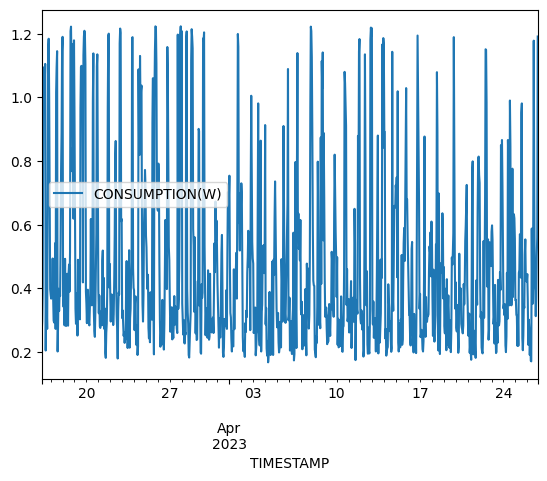

In [117]:
df_561_3.head(1000).plot()

<Axes: xlabel='TIMESTAMP'>

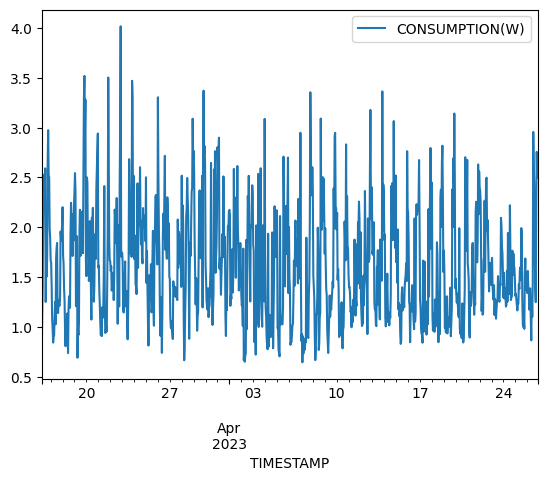

In [118]:
df_123 = df_12 +df_561_3

df_123.head(1000).plot()

In [127]:
df_561_4 = df.query("`BUILDING` == 561 and `FLOOR` == 4")
df_561_4['TIMESTAMP'] = pd.to_datetime(df_561_4['TIMESTAMP'])
df_561_4.drop(['BUILDING', 'FLOOR'], axis=1, inplace=True)
df_561_4.set_index('TIMESTAMP', inplace=True)
df_561_4['CONSUMPTION(W)'] /= 1000.0
df_561_4 = df_561_4.resample(rule='60T').sum()
df_561_4


C:\Users\hansung\AppData\Local\Temp\ipykernel_18536\4293854595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_561_4['TIMESTAMP'] = pd.to_datetime(df_561_4['TIMESTAMP'])
C:\Users\hansung\AppData\Local\Temp\ipykernel_18536\4293854595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_561_4.drop(['BUILDING', 'FLOOR'], axis=1, inplace=True)
C:\Users\hansung\AppData\Local\Temp\ipykernel_18536\4293854595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,CONSUMPTION(W)
TIMESTAMP,
2023-03-16 06:00:00,0.585
2023-03-16 07:00:00,1.274
2023-03-16 08:00:00,1.569
2023-03-16 09:00:00,1.434
2023-03-16 10:00:00,0.845
...,...
2023-08-30 06:00:00,1.925
2023-08-30 07:00:00,1.657
2023-08-30 08:00:00,1.915


<Axes: xlabel='TIMESTAMP'>

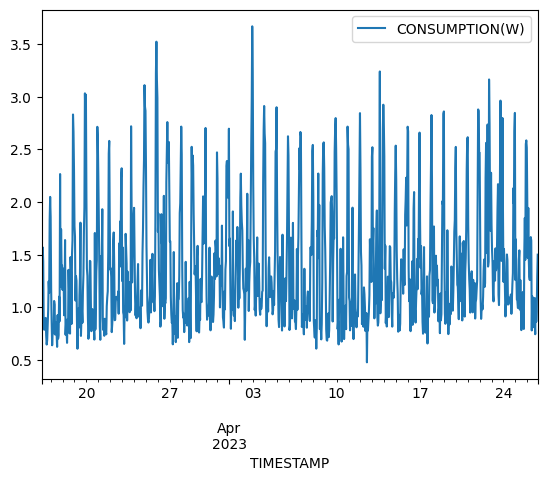

In [128]:
df_561_4.head(1000).plot()

<Axes: xlabel='TIMESTAMP'>

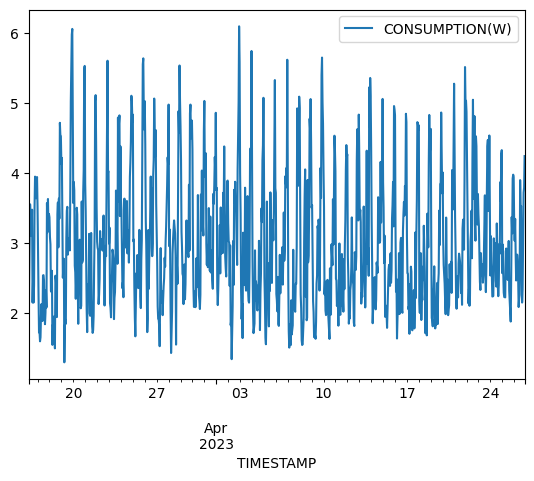

In [131]:
df_1234 = df_561_4 + df_123
df_1234.head(1000).plot()

<Axes: xlabel='TIMESTAMP'>

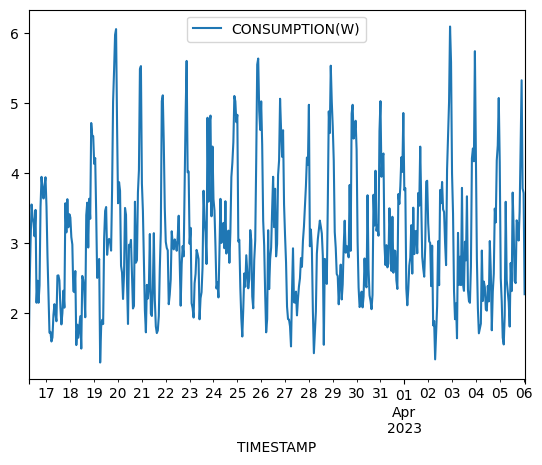

In [134]:
df_1234.iloc[:500].plot()

In [27]:
scaler = MinMaxScaler()

scaler.fit(df_561_1.values)

print(scaler.n_samples_seen_)   
print(scaler.data_min_)         
print(scaler.data_max_)  

4013
[0.039]
[1.24]


[[0.14404663]
 [0.04079933]
 [0.17818485]
 ...
 [0.30391341]
 [0.22481266]
 [0.26228143]]


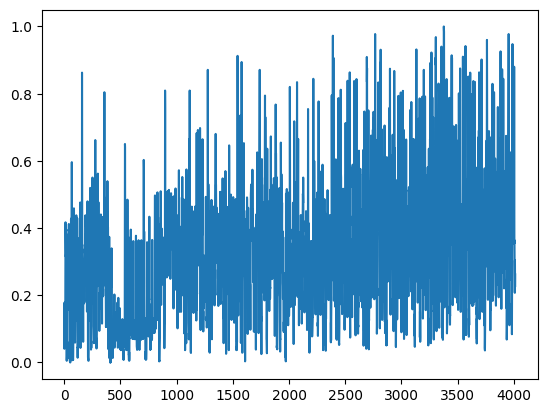

In [28]:
scaled_data = scaler.transform(df_561_1.values)
print(scaled_data)
plt.plot(scaled_data)

In [29]:
scaled_df = pd.DataFrame({'timestamp' : df_561_1.index, 'scaled_consumption' : scaled_data.flatten()})
scaled_df.set_index('timestamp', inplace=True)

scaled_df

,scaled_consumption
timestamp,
2023-03-16 06:00:00,0.144047
2023-03-16 07:00:00,0.040799
2023-03-16 08:00:00,0.178185
2023-03-16 09:00:00,0.148210
2023-03-16 10:00:00,0.144047
...,...
2023-08-30 06:00:00,0.209825
2023-08-30 07:00:00,0.207327
2023-08-30 08:00:00,0.303913


In [30]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4013 entries, 2023-03-16 06:00:00 to 2023-08-30 10:00:00
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   scaled_consumption  4013 non-null   float64
dtypes: float64(1)
memory usage: 62.7 KB


In [31]:
scaled_df.loc[:'2023-06-01 00:00:00'].describe()

,scaled_consumption
count,1843.000000
mean,0.261813
std,0.156524
min,0.000000
25%,0.119484
50%,0.265612
75%,0.376769
max,0.912573


In [32]:
scaled_df.loc['2023-06-01 00:00:00':].describe()

,scaled_consumption
count,2171.000000
mean,0.373496
std,0.186773
min,0.003331
25%,0.238135
50%,0.354704
75%,0.485429
max,1.000000


In [33]:
int(len(scaled_df) * 0.1)

401

In [34]:
scaled_df[:int(len(scaled_df) * 0.9)]

,scaled_consumption
timestamp,
2023-03-16 06:00:00,0.144047
2023-03-16 07:00:00,0.040799
2023-03-16 08:00:00,0.178185
2023-03-16 09:00:00,0.148210
2023-03-16 10:00:00,0.144047
...,...
2023-08-13 12:00:00,0.388843
2023-08-13 13:00:00,0.357202
2023-08-13 14:00:00,0.408826


In [139]:
# scaled_df = scaled_df.loc["2023-07-18 00:00:00" : '2023-08-31 23:59:00']
df = df_1234
train_df = df.iloc[:int(len(df) * 0.9)]

test_df = df[int(len(df) * 0.9):]

In [140]:
ow = 24
iw = ow * 2

train = train_df[:-ow]
train = train.to_numpy()

valid = train_df[-ow:]
valid = valid.to_numpy()

In [141]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, stride=1):
        L = y.shape[0]
        num_samples = (L - input_window - output_window) // stride + 1

        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x].reshape([-1,])

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y].reshape([-1,])

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len


In [148]:
train_dataset = windowDataset(train, input_window=iw, output_window=ow)
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4)

In [149]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [150]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states) 
        output = self.linear(lstm_out)
        
        return output, self.hidden

In [151]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size).to(device)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size).to(device)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        
        outputs = torch.zeros(batch_size, target_len, input_size).to(device)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :].to(device)
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out = out.squeeze(1)
            
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :].to(device)
            else:
                decoder_input = out.to(device)
            outputs[:,t,:] = out

        return outputs
	
    def predict(self, inputs, target_len):
        self.eval()
        inputs = inputs.unsqueeze(0)
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out = out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [ ]:
import gc

def objective(trial: optuna.Trial, X, Y, train_loader):
    param = {
        'lr' : trial.suggest_categorical('lr', [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]),
        'epoch' : trial.suggest_int('epoch', 1000, 7000, 1000),
        'hidden_size' : trial.suggest_categorical('hidden_size', [16, 32, 64, 128, 256])
    }

    print(param)

    model = lstm_encoder_decoder(input_size=1, hidden_size=param['hidden_size']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = param['lr'])
    criterion = nn.MSELoss()

    model.train()
    with tqdm(range(param['epoch'])) as tr:
        for i in tr:
            total_loss = 0.0
            for x,y in train_loader:
                optimizer.zero_grad()
                x = x.to(device).float()
                y = y.to(device).float()
                output = model(x, y, ow, 0.6)
                loss = criterion(output.to(device), y)
                loss.backward()
                optimizer.step()
                total_loss += loss.cpu().item()
            tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

    prediction = model.predict(torch.tensor(X[-iw:]).reshape(-1,1).to(device).float(), target_len=ow)

    score = mean_absolute_percentage_error(prediction, Y)
    print(score)

    gc.collect()

    return score

In [ ]:
from optuna.samplers import TPESampler

# TPESampler : Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
study = optuna.create_study(direction='minimize', sampler=TPESampler())

study.optimize(lambda trial : objective(trial, train, test, train_loader), n_trials = 100)

print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2023-11-18 11:26:16,476] A new study created in memory with name: no-name-0628dd2a-08b1-412e-96a5-00fa752eb4a2


{'lr': 0.01, 'epoch': 5000, 'hidden_size': 64}


100%|██████████| 5000/5000 [27:18<00:00,  3.05it/s, loss=0.00052]


0.32679183935959333


[I 2023-11-18 11:53:35,068] Trial 0 finished with value: 0.32679183935959333 and parameters: {'lr': 0.01, 'epoch': 5000, 'hidden_size': 64}. Best is trial 0 with value: 0.32679183935959333.


{'lr': 0.001, 'epoch': 3000, 'hidden_size': 256}


100%|██████████| 3000/3000 [18:52<00:00,  2.65it/s, loss=0.00002]
[I 2023-11-18 12:12:28,117] Trial 1 finished with value: 0.31337513271234574 and parameters: {'lr': 0.001, 'epoch': 3000, 'hidden_size': 256}. Best is trial 1 with value: 0.31337513271234574.


0.31337513271234574
{'lr': 1e-05, 'epoch': 5000, 'hidden_size': 256}


100%|██████████| 5000/5000 [31:29<00:00,  2.65it/s, loss=0.01110]


0.24097564168527183


[I 2023-11-18 12:43:57,962] Trial 2 finished with value: 0.24097564168527183 and parameters: {'lr': 1e-05, 'epoch': 5000, 'hidden_size': 256}. Best is trial 2 with value: 0.24097564168527183.


{'lr': 0.01, 'epoch': 7000, 'hidden_size': 64}


100%|██████████| 7000/7000 [39:07<00:00,  2.98it/s, loss=53.49706]
[I 2023-11-18 13:23:05,211] Trial 3 finished with value: 0.9635129255729198 and parameters: {'lr': 0.01, 'epoch': 7000, 'hidden_size': 64}. Best is trial 2 with value: 0.24097564168527183.


0.9635129255729198
{'lr': 1e-06, 'epoch': 3000, 'hidden_size': 32}


100%|██████████| 3000/3000 [15:27<00:00,  3.24it/s, loss=0.02754]
[I 2023-11-18 13:38:32,569] Trial 4 finished with value: 0.6392957242726832 and parameters: {'lr': 1e-06, 'epoch': 3000, 'hidden_size': 32}. Best is trial 2 with value: 0.24097564168527183.


0.6392957242726832
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [32:29<00:00,  3.08it/s, loss=0.01808]
[I 2023-11-18 14:11:01,780] Trial 5 finished with value: 0.17204722035577694 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}. Best is trial 5 with value: 0.17204722035577694.


0.17204722035577694
{'lr': 0.0001, 'epoch': 4000, 'hidden_size': 256}


100%|██████████| 4000/4000 [19:34<00:00,  3.41it/s, loss=0.00284]
[I 2023-11-18 14:30:35,996] Trial 6 finished with value: 0.22286506479742485 and parameters: {'lr': 0.0001, 'epoch': 4000, 'hidden_size': 256}. Best is trial 5 with value: 0.17204722035577694.


0.22286506479742485
{'lr': 1e-06, 'epoch': 1000, 'hidden_size': 32}


100%|██████████| 1000/1000 [04:36<00:00,  3.61it/s, loss=0.09066]
[I 2023-11-18 14:35:12,990] Trial 7 finished with value: 19.86468411442773 and parameters: {'lr': 1e-06, 'epoch': 1000, 'hidden_size': 32}. Best is trial 5 with value: 0.17204722035577694.


19.86468411442773
{'lr': 0.1, 'epoch': 3000, 'hidden_size': 256}


100%|██████████| 3000/3000 [15:06<00:00,  3.31it/s, loss=0.26460]
[I 2023-11-18 14:50:19,567] Trial 8 finished with value: 0.5977973145067649 and parameters: {'lr': 0.1, 'epoch': 3000, 'hidden_size': 256}. Best is trial 5 with value: 0.17204722035577694.


0.5977973145067649
{'lr': 0.0001, 'epoch': 4000, 'hidden_size': 16}


100%|██████████| 4000/4000 [17:32<00:00,  3.80it/s, loss=0.01097]
[I 2023-11-18 15:07:52,508] Trial 9 finished with value: 0.17042870204741778 and parameters: {'lr': 0.0001, 'epoch': 4000, 'hidden_size': 16}. Best is trial 9 with value: 0.17042870204741778.


0.17042870204741778
{'lr': 0.0001, 'epoch': 1000, 'hidden_size': 16}


100%|██████████| 1000/1000 [04:26<00:00,  3.76it/s, loss=0.01167]
[I 2023-11-18 15:12:18,725] Trial 10 finished with value: 0.22931684619990653 and parameters: {'lr': 0.0001, 'epoch': 1000, 'hidden_size': 16}. Best is trial 9 with value: 0.17042870204741778.


0.22931684619990653
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 16}


100%|██████████| 7000/7000 [31:06<00:00,  3.75it/s, loss=0.02641]
[I 2023-11-18 15:43:25,839] Trial 11 finished with value: 0.6123958150296359 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 16}. Best is trial 9 with value: 0.17042870204741778.


0.6123958150296359
{'lr': 0.0001, 'epoch': 6000, 'hidden_size': 128}


100%|██████████| 6000/6000 [26:55<00:00,  3.71it/s, loss=0.00224]
[I 2023-11-18 16:10:21,212] Trial 12 finished with value: 0.2916246215404057 and parameters: {'lr': 0.0001, 'epoch': 6000, 'hidden_size': 128}. Best is trial 9 with value: 0.17042870204741778.


0.2916246215404057
{'lr': 0.001, 'epoch': 5000, 'hidden_size': 16}


100%|██████████| 5000/5000 [22:14<00:00,  3.75it/s, loss=0.00469]
[I 2023-11-18 16:32:35,991] Trial 13 finished with value: 0.27765850981422285 and parameters: {'lr': 0.001, 'epoch': 5000, 'hidden_size': 16}. Best is trial 9 with value: 0.17042870204741778.


0.27765850981422285
{'lr': 0.1, 'epoch': 6000, 'hidden_size': 128}


100%|██████████| 6000/6000 [26:51<00:00,  3.72it/s, loss=0.12946]
[I 2023-11-18 16:59:27,740] Trial 14 finished with value: 0.4586663161865762 and parameters: {'lr': 0.1, 'epoch': 6000, 'hidden_size': 128}. Best is trial 9 with value: 0.17042870204741778.


0.4586663161865762
{'lr': 0.0001, 'epoch': 4000, 'hidden_size': 16}


100%|██████████| 4000/4000 [19:15<00:00,  3.46it/s, loss=0.01046]
[I 2023-11-18 17:18:43,637] Trial 15 finished with value: 0.19617055496177468 and parameters: {'lr': 0.0001, 'epoch': 4000, 'hidden_size': 16}. Best is trial 9 with value: 0.17042870204741778.


0.19617055496177468
{'lr': 1e-05, 'epoch': 2000, 'hidden_size': 256}


100%|██████████| 2000/2000 [09:43<00:00,  3.43it/s, loss=0.01208]
[I 2023-11-18 17:28:27,550] Trial 16 finished with value: 0.22671085427979398 and parameters: {'lr': 1e-05, 'epoch': 2000, 'hidden_size': 256}. Best is trial 9 with value: 0.17042870204741778.


0.22671085427979398
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 16}


100%|██████████| 6000/6000 [28:07<00:00,  3.56it/s, loss=0.02561]
[I 2023-11-18 17:56:34,885] Trial 17 finished with value: 0.6090741650088695 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 16}. Best is trial 9 with value: 0.17042870204741778.


0.6090741650088695
{'lr': 1e-06, 'epoch': 4000, 'hidden_size': 32}


100%|██████████| 4000/4000 [18:00<00:00,  3.70it/s, loss=0.02535]
[I 2023-11-18 18:14:35,261] Trial 18 finished with value: 0.5915903783359593 and parameters: {'lr': 1e-06, 'epoch': 4000, 'hidden_size': 32}. Best is trial 9 with value: 0.17042870204741778.


0.5915903783359593
{'lr': 0.0001, 'epoch': 5000, 'hidden_size': 128}


100%|██████████| 5000/5000 [22:50<00:00,  3.65it/s, loss=0.00260]
[I 2023-11-18 18:37:25,919] Trial 19 finished with value: 0.2211915180469147 and parameters: {'lr': 0.0001, 'epoch': 5000, 'hidden_size': 128}. Best is trial 9 with value: 0.17042870204741778.


0.2211915180469147
{'lr': 0.001, 'epoch': 2000, 'hidden_size': 64}


100%|██████████| 2000/2000 [09:34<00:00,  3.48it/s, loss=0.00143]
[I 2023-11-18 18:47:00,353] Trial 20 finished with value: 0.29528857117590596 and parameters: {'lr': 0.001, 'epoch': 2000, 'hidden_size': 64}. Best is trial 9 with value: 0.17042870204741778.


0.29528857117590596
{'lr': 0.0001, 'epoch': 4000, 'hidden_size': 16}


100%|██████████| 4000/4000 [19:59<00:00,  3.33it/s, loss=0.01112]
[I 2023-11-18 19:07:00,261] Trial 21 finished with value: 0.21054725868504187 and parameters: {'lr': 0.0001, 'epoch': 4000, 'hidden_size': 16}. Best is trial 9 with value: 0.17042870204741778.


0.21054725868504187
{'lr': 0.0001, 'epoch': 4000, 'hidden_size': 16}


100%|██████████| 4000/4000 [18:06<00:00,  3.68it/s, loss=0.01099]
[I 2023-11-18 19:25:07,380] Trial 22 finished with value: 0.18166485294884102 and parameters: {'lr': 0.0001, 'epoch': 4000, 'hidden_size': 16}. Best is trial 9 with value: 0.17042870204741778.


0.18166485294884102
{'lr': 0.0001, 'epoch': 3000, 'hidden_size': 16}


100%|██████████| 3000/3000 [13:46<00:00,  3.63it/s, loss=0.01073]
[I 2023-11-18 19:38:53,907] Trial 23 finished with value: 0.2042551161578947 and parameters: {'lr': 0.0001, 'epoch': 3000, 'hidden_size': 16}. Best is trial 9 with value: 0.17042870204741778.


0.2042551161578947
{'lr': 0.0001, 'epoch': 5000, 'hidden_size': 16}


100%|██████████| 5000/5000 [23:19<00:00,  3.57it/s, loss=0.01012]
[I 2023-11-18 20:02:13,450] Trial 24 finished with value: 0.20143081479255856 and parameters: {'lr': 0.0001, 'epoch': 5000, 'hidden_size': 16}. Best is trial 9 with value: 0.17042870204741778.


0.20143081479255856
{'lr': 0.1, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [28:38<00:00,  3.49it/s, loss=0.16861]
[I 2023-11-18 20:30:51,923] Trial 25 finished with value: 0.2162422639511077 and parameters: {'lr': 0.1, 'epoch': 6000, 'hidden_size': 256}. Best is trial 9 with value: 0.17042870204741778.


0.2162422639511077
{'lr': 0.01, 'epoch': 2000, 'hidden_size': 16}


100%|██████████| 2000/2000 [08:47<00:00,  3.79it/s, loss=0.00590]
[I 2023-11-18 20:39:39,175] Trial 26 finished with value: 0.2824587511962003 and parameters: {'lr': 0.01, 'epoch': 2000, 'hidden_size': 16}. Best is trial 9 with value: 0.17042870204741778.


0.2824587511962003
{'lr': 1e-05, 'epoch': 4000, 'hidden_size': 16}


100%|██████████| 4000/4000 [17:40<00:00,  3.77it/s, loss=0.01637]
[I 2023-11-18 20:57:19,509] Trial 27 finished with value: 0.3545038342085971 and parameters: {'lr': 1e-05, 'epoch': 4000, 'hidden_size': 16}. Best is trial 9 with value: 0.17042870204741778.


0.3545038342085971
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [33:33<00:00,  3.48it/s, loss=0.01719]
[I 2023-11-18 21:30:53,339] Trial 28 finished with value: 0.17420796048164544 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}. Best is trial 9 with value: 0.17042870204741778.


0.17420796048164544
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [33:48<00:00,  3.45it/s, loss=0.01728]
[I 2023-11-18 22:04:42,166] Trial 29 finished with value: 0.17656123821163114 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}. Best is trial 9 with value: 0.17042870204741778.


0.17656123821163114
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [33:59<00:00,  3.43it/s, loss=0.01697]
[I 2023-11-18 22:38:41,646] Trial 30 finished with value: 0.17308419207767659 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}. Best is trial 9 with value: 0.17042870204741778.


0.17308419207767659
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [33:30<00:00,  3.48it/s, loss=0.01771]
[I 2023-11-18 23:12:11,893] Trial 31 finished with value: 0.1690855041356052 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}. Best is trial 31 with value: 0.1690855041356052.


0.1690855041356052
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [33:16<00:00,  3.51it/s, loss=0.01654]
[I 2023-11-18 23:45:28,365] Trial 32 finished with value: 0.17583687273644186 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}. Best is trial 31 with value: 0.1690855041356052.


0.17583687273644186
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [28:30<00:00,  3.51it/s, loss=0.01821]
[I 2023-11-19 00:13:58,557] Trial 33 finished with value: 0.16593623638617697 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.16593623638617697
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [28:31<00:00,  3.51it/s, loss=0.01749]
[I 2023-11-19 00:42:29,778] Trial 34 finished with value: 0.17925141411653808 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.17925141411653808
{'lr': 0.01, 'epoch': 5000, 'hidden_size': 64}


100%|██████████| 5000/5000 [22:20<00:00,  3.73it/s, loss=0.00136]
[I 2023-11-19 01:04:50,448] Trial 35 finished with value: 0.19447416808101137 and parameters: {'lr': 0.01, 'epoch': 5000, 'hidden_size': 64}. Best is trial 33 with value: 0.16593623638617697.


0.19447416808101137
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [28:32<00:00,  3.50it/s, loss=0.01839]
[I 2023-11-19 01:33:22,976] Trial 36 finished with value: 0.20100291800187628 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.20100291800187628
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [28:33<00:00,  3.50it/s, loss=0.01761]
[I 2023-11-19 02:01:56,394] Trial 37 finished with value: 0.19952394327610323 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.19952394327610323
{'lr': 1e-05, 'epoch': 5000, 'hidden_size': 32}


100%|██████████| 5000/5000 [22:10<00:00,  3.76it/s, loss=0.01230]
[I 2023-11-19 02:24:06,791] Trial 38 finished with value: 0.1962986488369408 and parameters: {'lr': 1e-05, 'epoch': 5000, 'hidden_size': 32}. Best is trial 33 with value: 0.16593623638617697.


0.1962986488369408
{'lr': 0.001, 'epoch': 5000, 'hidden_size': 256}


100%|██████████| 5000/5000 [23:48<00:00,  3.50it/s, loss=0.00004]
[I 2023-11-19 02:47:55,121] Trial 39 finished with value: 0.2847341345880201 and parameters: {'lr': 0.001, 'epoch': 5000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.2847341345880201
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 64}


100%|██████████| 7000/7000 [31:22<00:00,  3.72it/s, loss=0.02149]
[I 2023-11-19 03:19:17,772] Trial 40 finished with value: 0.4380436295466568 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 64}. Best is trial 33 with value: 0.16593623638617697.


0.4380436295466568
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [33:19<00:00,  3.50it/s, loss=0.01668]
[I 2023-11-19 03:52:37,760] Trial 41 finished with value: 0.17484078464266908 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.17484078464266908
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [33:18<00:00,  3.50it/s, loss=0.01717]
[I 2023-11-19 04:25:56,271] Trial 42 finished with value: 0.17144541579748554 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.17144541579748554
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [28:35<00:00,  3.50it/s, loss=0.01799]
[I 2023-11-19 04:54:31,856] Trial 43 finished with value: 0.1793259020403585 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.1793259020403585
{'lr': 0.01, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [33:36<00:00,  3.47it/s, loss=778.06803] 
[I 2023-11-19 05:28:08,387] Trial 44 finished with value: 0.9707488320302314 and parameters: {'lr': 0.01, 'epoch': 7000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.9707488320302314
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [28:37<00:00,  3.49it/s, loss=0.01886]
[I 2023-11-19 05:56:46,351] Trial 45 finished with value: 0.17374099443030308 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.17374099443030308
{'lr': 0.1, 'epoch': 7000, 'hidden_size': 128}


100%|██████████| 7000/7000 [30:54<00:00,  3.77it/s, loss=0.13264]
[I 2023-11-19 06:27:41,220] Trial 46 finished with value: 0.4646487562295601 and parameters: {'lr': 0.1, 'epoch': 7000, 'hidden_size': 128}. Best is trial 33 with value: 0.16593623638617697.


0.4646487562295601
{'lr': 1e-06, 'epoch': 3000, 'hidden_size': 32}


100%|██████████| 3000/3000 [13:18<00:00,  3.76it/s, loss=0.02752]
[I 2023-11-19 06:40:59,619] Trial 47 finished with value: 0.6473268009900137 and parameters: {'lr': 1e-06, 'epoch': 3000, 'hidden_size': 32}. Best is trial 33 with value: 0.16593623638617697.


0.6473268009900137
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [28:34<00:00,  3.50it/s, loss=0.01747]
[I 2023-11-19 07:09:33,808] Trial 48 finished with value: 0.17241641639043845 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.17241641639043845
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [33:20<00:00,  3.50it/s, loss=0.01690]
[I 2023-11-19 07:42:54,924] Trial 49 finished with value: 0.17386839241951546 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.17386839241951546
{'lr': 0.1, 'epoch': 5000, 'hidden_size': 256}


100%|██████████| 5000/5000 [23:53<00:00,  3.49it/s, loss=35920.28854]
[I 2023-11-19 08:06:48,946] Trial 50 finished with value: 0.9979570174150812 and parameters: {'lr': 0.1, 'epoch': 5000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.9979570174150812
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [28:32<00:00,  3.50it/s, loss=0.01845]
[I 2023-11-19 08:35:21,933] Trial 51 finished with value: 0.18216887669286685 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.18216887669286685
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [28:35<00:00,  3.50it/s, loss=0.01816]
[I 2023-11-19 09:03:57,230] Trial 52 finished with value: 0.17016192031181876 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.17016192031181876
{'lr': 0.001, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [28:44<00:00,  3.48it/s, loss=0.00014]
[I 2023-11-19 09:32:41,944] Trial 53 finished with value: 0.3035400578564335 and parameters: {'lr': 0.001, 'epoch': 6000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.3035400578564335
{'lr': 1e-06, 'epoch': 5000, 'hidden_size': 128}


100%|██████████| 5000/5000 [22:30<00:00,  3.70it/s, loss=0.01885]
[I 2023-11-19 09:55:12,114] Trial 54 finished with value: 0.1896508434345935 and parameters: {'lr': 1e-06, 'epoch': 5000, 'hidden_size': 128}. Best is trial 33 with value: 0.16593623638617697.


0.1896508434345935
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [34:46<00:00,  3.36it/s, loss=0.01733]
[I 2023-11-19 10:29:58,574] Trial 55 finished with value: 0.17199451335428714 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.17199451335428714
{'lr': 1e-05, 'epoch': 7000, 'hidden_size': 64}


100%|██████████| 7000/7000 [32:15<00:00,  3.62it/s, loss=0.01068]
[I 2023-11-19 11:02:14,113] Trial 56 finished with value: 0.23034694763006738 and parameters: {'lr': 1e-05, 'epoch': 7000, 'hidden_size': 64}. Best is trial 33 with value: 0.16593623638617697.


0.23034694763006738
{'lr': 0.0001, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [33:31<00:00,  3.48it/s, loss=0.00061]
[I 2023-11-19 11:35:45,336] Trial 57 finished with value: 0.35370683361706384 and parameters: {'lr': 0.0001, 'epoch': 7000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.35370683361706384
{'lr': 1e-06, 'epoch': 4000, 'hidden_size': 32}


100%|██████████| 4000/4000 [17:41<00:00,  3.77it/s, loss=0.02650]
[I 2023-11-19 11:53:26,820] Trial 58 finished with value: 0.6050126219031907 and parameters: {'lr': 1e-06, 'epoch': 4000, 'hidden_size': 32}. Best is trial 33 with value: 0.16593623638617697.


0.6050126219031907
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [33:21<00:00,  3.50it/s, loss=0.01710]
[I 2023-11-19 12:26:48,833] Trial 59 finished with value: 0.1738412908241356 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.1738412908241356
{'lr': 0.0001, 'epoch': 3000, 'hidden_size': 256}


100%|██████████| 3000/3000 [14:22<00:00,  3.48it/s, loss=0.00272]
[I 2023-11-19 12:41:11,419] Trial 60 finished with value: 0.29159492675274357 and parameters: {'lr': 0.0001, 'epoch': 3000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.29159492675274357
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [29:00<00:00,  3.45it/s, loss=0.01737]
[I 2023-11-19 13:10:12,285] Trial 61 finished with value: 0.17968241899607543 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.17968241899607543
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [34:09<00:00,  3.41it/s, loss=0.01749]
[I 2023-11-19 13:44:22,294] Trial 62 finished with value: 0.1720745478469873 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.1720745478469873
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 16}


100%|██████████| 6000/6000 [27:12<00:00,  3.68it/s, loss=0.02606]
[I 2023-11-19 14:11:34,467] Trial 63 finished with value: 0.6050356744823193 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 16}. Best is trial 33 with value: 0.16593623638617697.


0.6050356744823193
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [33:21<00:00,  3.50it/s, loss=0.01735]
[I 2023-11-19 14:44:56,336] Trial 64 finished with value: 0.16967552809399264 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.16967552809399264
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [33:34<00:00,  3.47it/s, loss=0.01724]
[I 2023-11-19 15:18:31,032] Trial 65 finished with value: 0.16683481930985508 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.16683481930985508
{'lr': 0.001, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [34:01<00:00,  3.43it/s, loss=0.00004]
[I 2023-11-19 15:52:32,291] Trial 66 finished with value: 0.3129520834366967 and parameters: {'lr': 0.001, 'epoch': 7000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.3129520834366967
{'lr': 0.01, 'epoch': 7000, 'hidden_size': 128}


100%|██████████| 7000/7000 [31:24<00:00,  3.71it/s, loss=702.91714] 
[I 2023-11-19 16:23:57,285] Trial 67 finished with value: 0.9806570426554999 and parameters: {'lr': 0.01, 'epoch': 7000, 'hidden_size': 128}. Best is trial 33 with value: 0.16593623638617697.


0.9806570426554999
{'lr': 0.0001, 'epoch': 4000, 'hidden_size': 16}


100%|██████████| 4000/4000 [17:55<00:00,  3.72it/s, loss=0.01099]
[I 2023-11-19 16:41:53,007] Trial 68 finished with value: 0.2145425336418277 and parameters: {'lr': 0.0001, 'epoch': 4000, 'hidden_size': 16}. Best is trial 33 with value: 0.16593623638617697.


0.2145425336418277
{'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}


100%|██████████| 7000/7000 [34:09<00:00,  3.42it/s, loss=0.01718]
[I 2023-11-19 17:16:02,743] Trial 69 finished with value: 0.17171507511539144 and parameters: {'lr': 1e-06, 'epoch': 7000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.17171507511539144
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [29:22<00:00,  3.40it/s, loss=0.01806]
[I 2023-11-19 17:45:25,836] Trial 70 finished with value: 0.16960863301457607 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.16960863301457607
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [28:47<00:00,  3.47it/s, loss=0.01795]
[I 2023-11-19 18:14:13,576] Trial 71 finished with value: 0.17011515105118344 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.17011515105118344
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}


100%|██████████| 6000/6000 [28:35<00:00,  3.50it/s, loss=0.01804]
[I 2023-11-19 18:42:49,368] Trial 72 finished with value: 0.18334849068600292 and parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.18334849068600292
{'lr': 1e-06, 'epoch': 5000, 'hidden_size': 256}


100%|██████████| 5000/5000 [23:51<00:00,  3.49it/s, loss=0.01809]
[I 2023-11-19 19:06:40,595] Trial 73 finished with value: 0.1721476371638833 and parameters: {'lr': 1e-06, 'epoch': 5000, 'hidden_size': 256}. Best is trial 33 with value: 0.16593623638617697.


0.1721476371638833
{'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}


  5%|▍         | 289/6000 [01:23<27:39,  3.44it/s, loss=0.03222]
[W 2023-11-19 19:08:04,607] Trial 74 failed with parameters: {'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\hansung\AppData\Local\Temp\ipykernel_40888\354521937.py", line 6, in <lambda>
    study.optimize(lambda trial : objective(trial, train, test, train_loader), n_trials = 100)
  File "C:\Users\hansung\AppData\Local\Temp\ipykernel_40888\3514944431.py", line 24, in objective
    output = model(x, y, ow, 0.6)
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\torch\nn\modules\module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\torch\nn\modules\module.py",

KeyboardInterrupt: 

In [ ]:
study.best_trial

FrozenTrial(number=33, state=TrialState.COMPLETE, values=[0.16593623638617697], datetime_start=datetime.datetime(2023, 11, 18, 23, 45, 28, 366166), datetime_complete=datetime.datetime(2023, 11, 19, 0, 13, 58, 557509), params={'lr': 1e-06, 'epoch': 6000, 'hidden_size': 256}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': CategoricalDistribution(choices=(1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1)), 'epoch': IntDistribution(high=7000, log=False, low=1000, step=1000), 'hidden_size': CategoricalDistribution(choices=(16, 32, 64, 128, 256))}, trial_id=33, value=None)

In [160]:
learning_rate=1e-6
epoch = 6000

model = lstm_encoder_decoder(input_size=1, hidden_size=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

DeferredCudaCallError: CUDA call failed lazily at initialization with error: module 'torch' has no attribute 'version'

CUDA call was originally invoked at:

  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\traitlets\config\application.py", line 1046, in launch_instance
    app.start()
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
    self.io_loop.start()
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\asyncio\base_events.py", line 601, in run_forever
    self._run_once()
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\asyncio\base_events.py", line 1905, in _run_once
    handle._run()
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
    await self.process_one()
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
    await dispatch(*args)
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
    await result
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
    reply_content = await reply_content
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
    res = shell.run_cell(
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
    return super().run_cell(*args, **kwargs)
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
    result = self._run_cell(
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
    result = runner(coro)
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\hansung\AppData\Local\Temp\ipykernel_18536\2477554986.py", line 8, in <module>
    import torch
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 680, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\torch\__init__.py", line 1332, in <module>
    _C._initExtension(manager_path())
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 680, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\torch\cuda\__init__.py", line 244, in <module>
    _lazy_call(_check_capability)
  File "c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\torch\cuda\__init__.py", line 241, in _lazy_call
    _queued_calls.append((callable, traceback.format_stack()))


In [152]:
model.train()
with tqdm(range(6000)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6)
            loss = criterion(output.to(device), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

prediction = model.predict(torch.tensor(train[-iw:]).reshape(-1,1).to(device).float(), target_len=ow)

score = mean_absolute_percentage_error(prediction, valid)
print(score)

NameError: name 'model' is not defined

In [ ]:
predict = model.predict(torch.tensor(train[-200:]).reshape(-1,1).float(), target_len=ow)

# predict = min_max_scaler.inverse_transform(predict.reshape(-1,1))
# real = min_max_scaler.inverse_transform(real.reshape(-1,1))

In [ ]:
prediction

array([1.3331097, 1.2992467, 1.2144351, 1.1339518, 1.0809003, 1.0562695,
       1.0529753, 1.0623951, 1.0772738, 1.0927666, 1.1064062, 1.1175083,
       1.1264204, 1.1338737, 1.1405581, 1.1469212, 1.1531352, 1.1591591,
       1.1648325, 1.1699609, 1.174374 , 1.1779553, 1.180647 , 1.1824425],
      dtype=float32)

0.28196768476323525


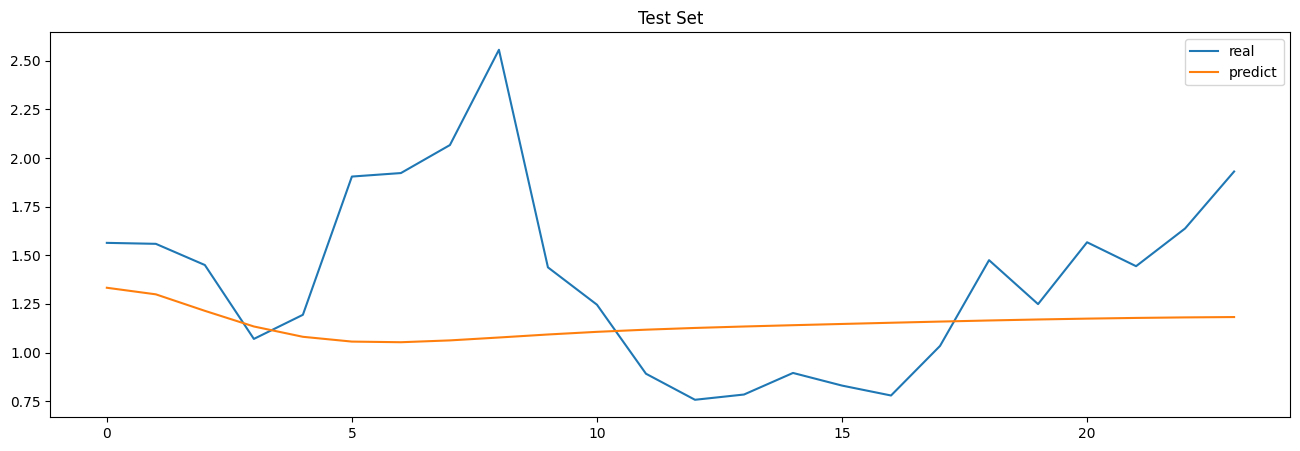

In [ ]:
print(mean_absolute_percentage_error(test, prediction))

plt.figure(figsize=(16,5))
plt.plot(test, label="real")
plt.plot(prediction, label="predict")

plt.title("Test Set")
plt.legend()
plt.show()